In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm_notebook
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Prep

In [3]:
def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)
            
    return X, Y

In [4]:
doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

In [5]:
Y

array([[ 7, 10,  2,  3, 10,  2,  7,  3,  7,  2,  7, 11,  3,  7, 10,  7,
        11,  2,  7, 10,  2, 11,  2,  0, 10,  2,  7,  2,  0,  5,  2,  7,
        11,  0,  5,  7,  7, 11,  2,  5,  7,  8, 11,  2,  0,  7,  8,  9,
         2,  0,  5,  8,  9,  4,  0,  5,  7,  9,  4, 12,  5,  7,  8,  4,
        12,  6,  7,  8,  9, 12,  6,  1,  8,  9,  4,  6,  1,  9,  4, 12,
         1,  4, 12,  6]])

## Initialization

In [6]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    
    assert(WRD_EMB.shape == (vocab_size, emb_size))
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    
    assert(W.shape == (output_size, input_size))
    return W

def initialize_parameters(vocab_size, emb_size):
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

## Forward Propagation

In [7]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    return softmax_out, caches

## Cost Function

In [8]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.log(softmax_out[Y.flatten(), np.arange(Y.shape[1])] + 0.001))
    return cost

## Backward Propagation

In [9]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = Y.shape[1]
    softmax_out[Y.flatten(), np.arange(m)] -= 1.0
    dL_dZ = softmax_out
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    parameters['WRD_EMB'][inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']
    

In [10]:
from datetime import datetime

import matplotlib.pyplot as plt


def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=False, plot_cost=True):
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            cost = cross_entropy(softmax_out, Y_batch)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print('training time: {}'.format(end_time - begin_time))
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

Cost after epoch 0: 2.5521331025990563
Cost after epoch 10: 2.551800029902041
Cost after epoch 20: 2.5514533303291587
Cost after epoch 30: 2.551073344437463
Cost after epoch 40: 2.5506401608043645
Cost after epoch 50: 2.5501323444152617
Cost after epoch 60: 2.5495381996202786
Cost after epoch 70: 2.5488259661037356
Cost after epoch 80: 2.547966508155682
Cost after epoch 90: 2.546927892625489
Cost after epoch 100: 2.5456735761047127
Cost after epoch 110: 2.544191329304913
Cost after epoch 120: 2.542419262769871
Cost after epoch 130: 2.5403033899686753
Cost after epoch 140: 2.5377858509876545
Cost after epoch 150: 2.534801977117158
Cost after epoch 160: 2.531348860950112
Cost after epoch 170: 2.527313261820005
Cost after epoch 180: 2.5226125706575573
Cost after epoch 190: 2.5171696449033902
Cost after epoch 200: 2.5109105076931217
Cost after epoch 210: 2.5039065344436127
Cost after epoch 220: 2.4960241802283605
Cost after epoch 230: 2.487229329150902
Cost after epoch 240: 2.4775357619215

Cost after epoch 2560: 2.0398531956009394
Cost after epoch 2570: 2.039849867273488
Cost after epoch 2580: 2.0398483814027206
Cost after epoch 2590: 2.0398487233192104
Cost after epoch 2600: 2.0398508746870814
Cost after epoch 2610: 2.039854768150822
Cost after epoch 2620: 2.0398603528371795
Cost after epoch 2630: 2.0398675995997233
Cost after epoch 2640: 2.039876475111716
Cost after epoch 2650: 2.039886942979935
Cost after epoch 2660: 2.0398987733816494
Cost after epoch 2670: 2.0399120374560056
Cost after epoch 2680: 2.039926707759089
Cost after epoch 2690: 2.039942736762036
Cost after epoch 2700: 2.0399600746320776
Cost after epoch 2710: 2.039978361563965
Cost after epoch 2720: 2.039997772976785
Cost after epoch 2730: 2.0400182848572292
Cost after epoch 2740: 2.0400398402384208
Cost after epoch 2750: 2.0400623806644522
Cost after epoch 2760: 2.040085452207203
Cost after epoch 2770: 2.040109312918687
Cost after epoch 2780: 2.0401339434165218
Cost after epoch 2790: 2.0401592818577927
Co

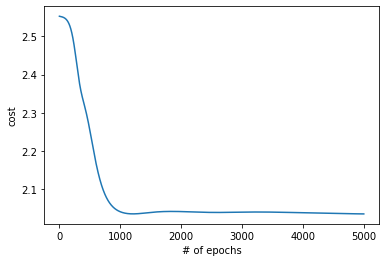

In [11]:
paras = skipgram_model_training(X, Y, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)

## Evaluate

In [12]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

In [13]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

investing's neighbor words: ['the', 'stock', 'beating', "loser's"]
game's neighbor words: ['is', "loser's", 'a', 'beating']
of's neighbor words: ['the', 'of', 'costs', 'beating']
after's neighbor words: ['of', 'the', 'deduction', 'costs']
is's neighbor words: ['game', 'market', "loser's", 'a']
beating's neighbor words: ['market', 'stock', 'costs', 'investing']
loser's's neighbor words: ['game', 'market', "loser's", 'a']
the's neighbor words: ['is', 'of', 'beating', 'stock']
stock's neighbor words: ['investing', 'a', 'is', 'market']
market's neighbor words: ['is', "loser's", 'a', 'beating']
deduction's neighbor words: ['costs', 'after', 'the', 'beating']
costs's neighbor words: ['beating', 'of', 'deduction', 'the']
a's neighbor words: ['game', 'market', "loser's", 'a']
